**Algoritmos para Big Data**

**2022/23**

# Binary classification
This lecture is about binary classification in a discrete space. We will setup a ML processing pipeline to achieve our goals. The dataset relates to the domain of banking industry, specifically about credit-cards (fraud detection and/or consuming profile)

# ML pipelines

As stated in the Spark's programming guide, **"ML Pipelines provide a uniform set of high-level APIs built on top of DataFrames that help users create and tune practical machine learning pipelines."**

Hence, it is possible to combine multiple algorithms into a single pipeline, or workflow. Besides DataFrames, it involves the following:
1. Transformer: an algorithm which can transform one DataFrame into another DataFrame. For example, an ML model is a Transformer which transforms a DataFrame with features into a DataFrame with predictions.
2. Estimator: an algorithm which can be fit on a DataFrame to produce a Transformer. For example, a learning algorithm is an Estimator which trains on a DataFrame and produces a model.
3. Pipeline: the way to chain multiple Transformers and Estimators together to specify an ML workflow. 4. Parameter: all Transformers and Estimators share a common API for specifying parameters.
Further details can be found in http://spark.apache.org/docs/latest/ml-pipeline.html



Recall that, in general, a typical ML workflow is designed to work as depicted below:

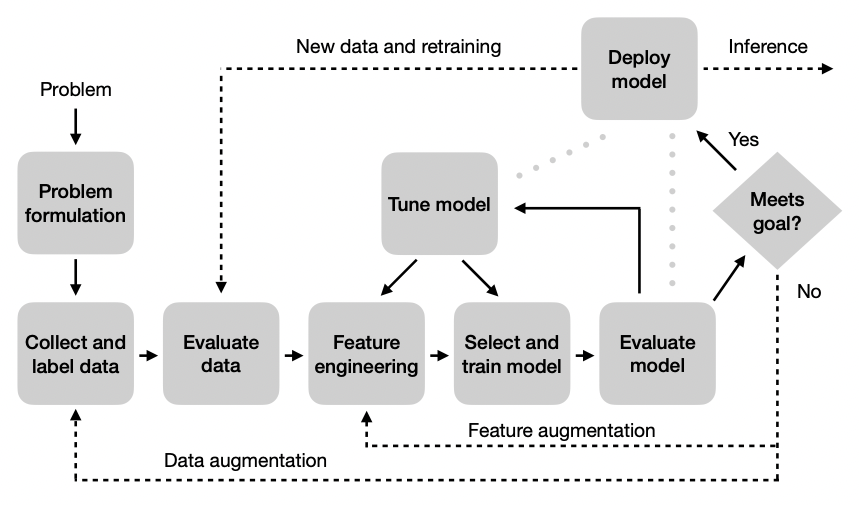

# Problem formulation

This exercise is about credit card fraud detection. Our case-study is based on a Kaggle dataset that has been generated by Erik Altman, who was aiming to provide realistic synthetic data about credit card transactions. Details can be found in https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions .

In the end, it is a binary classification problem.

Basically, the functional requirements for the Spark program we are about to create are as follows:
1. To load the dataset under analysis and making sure it can be further processed by a ML classifier.
2. To create a classification model supported by a SVM algorithm that is fit for the purpose.
3. To evaluate the quality of the classifier that has been built.

As for data availability, you can find the archive **credit-card-transaction.zip** in the location mentioned in the Moodle's ABD page.


**Context**

There is no great availability of credit card transaction data for training fraud detection models and other uses, such as analyzing similar purchase patterns. Indeed, this type of data is critical to the owners like banks and alike, but quite understandably it would not be made public. (And if so, with few transactions and short time-span) 



**Market data**

This set of data has more than 20 million transactions generated from a multi-agent virtual world simulation performed by IBM. The data covers 2000 (synthetic) consumers resident in the United States, but who travel the world. The data also covers decades of purchases, and includes multiple cards from many of the consumers.

Analyses of the data suggest that it is a reasonable match for real data in many dimensions, e.g. fraud rates, purchase amounts, Merchant Category Codes (MCCs), and other metrics. In addition, all columns except merchant name have their "natural" value. Such natural values can be helpful in feature engineering of models.

F1 (F-score or F-measure) will provide a useful score for models predicting whether a particular transaction is fraudulent or not.

Notice that there are three files available, respectively with information about cards, users and transactions.

# Initial settings

Prior to any computation, let us set some imports and useful functions

## Additional packages and imports

In [1]:
# Some general imports 

import os
import sys

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")

# Useful visualization functions

Some functions that we can use to plot data but as Python dataframes.

**Disclaimer**: these functions are broadly distributed among users. Further adjustments are needed and/or advisable. Feel free to use your own plotting functions. See https://seaborn.pydata.org/

Remember: *"A picture is worth a thousand words"*

In [2]:
def plotLine(df, xcol, ycol):
    return sns.lineplot(data=df, x=xcol, y=ycol)

In [3]:
def plotBar(df, xcol, ycol, huecol=None):
    return sns.barplot(data=df, x=xcol, y=ycol, hue=huecol)

In [4]:
def plotScatter(df, xcol, ycol, huecol=None):
    return sns.scatterplot(data=df, x=xcol, y=ycol, hue=huecol)

In [5]:
def plotScatterMatrix(df, huecol=None):
    return sns.pairplot(data=df, hue=huecol)

In [6]:
def plotCorrelationMatrix(df, annot=False):
    # compute the correlation matrix
    corr = df.corr()
    
    # generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # generate a custom colormap
    #cmap = sns.divergent_palette(230, 20, as_cmap=True)
    
    cmap='coolwarm'

    # draw the heatmap with the mask and correct aspect ratio
    return sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=annot,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [7]:
def plotBox(df, xcol, ycol, huecol=None, kind='box'):
    return sns.catplot(data=df, x=xcol, y=ycol, hue=huecol, kind=kind)

# Collect and label data

## Data ingestion

In [8]:
! head -n 2 credit-card-transactions/sd254_cards.csv
! tail -n 1 credit-card-transactions/sd254_cards.csv

User,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1999,1,Visa,Credit,4994011318343994,12/2020,120,YES,1,$14400,05/2017,2017,No


In [9]:
! head -n 2 credit-card-transactions/sd254_users.csv
! tail -n 1 credit-card-transactions/sd254_users.csv

Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
Kenia Harris,21,60,1998,11,Female,472 Ocean View Street,,Merrimack,NH,03054,42.86,-71.48,$32325,$65909,$181261,673,2


In [10]:
! head -n 2 
! tail -n 1 

User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,,No
1999,1,2020,2,28,23:10,$45.13,Chip Transaction,4751695835751691036,Merrimack,NH,3054.0,5814,,No


In [11]:
# Some Spark related imports we will use hereafter

import sys

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## Reading the datasets

In [12]:
filename = "credit-card-transactions/sd254_cards.csv"
df_cards = spark.read.csv(filename, header="true", inferSchema="true", sep=',')


In [13]:
filename = "credit-card-transactions/sd254_users.csv"
df_users = 


In [14]:
# We may ask to inferSchema now, but later on we can provide the schema to speed up 
# reading, as the file is quite big

filename = "credit-card-transactions/credit_card_transactions-ibm_v2.csv"
df_transactions =


## Checking data
Schema, show and count

### Cards

In [15]:
# check the data - schema and count

df_cards.
df_cards.
cards_count = 
cards_count

root
 |-- User: integer (nullable = true)
 |-- CARD INDEX: integer (nullable = true)
 |-- Card Brand: string (nullable = true)
 |-- Card Type: string (nullable = true)
 |-- Card Number: long (nullable = true)
 |-- Expires: string (nullable = true)
 |-- CVV: integer (nullable = true)
 |-- Has Chip: string (nullable = true)
 |-- Cards Issued: integer (nullable = true)
 |-- Credit Limit: string (nullable = true)
 |-- Acct Open Date: string (nullable = true)
 |-- Year PIN last Changed: integer (nullable = true)
 |-- Card on Dark Web: string (nullable = true)

-RECORD 0---------------------------------
 User                  | 0                
 CARD INDEX            | 0                
 Card Brand            | Visa             
 Card Type             | Debit            
 Card Number           | 4344676511950444 
 Expires               | 12/2022          
 CVV                   | 623              
 Has Chip              | YES              
 Cards Issued          | 2                
 Credit 

6146

### Users

In [16]:
df_users.
df_users.
users_count = 
users_count

root
 |-- Person: string (nullable = true)
 |-- Current Age: integer (nullable = true)
 |-- Retirement Age: integer (nullable = true)
 |-- Birth Year: integer (nullable = true)
 |-- Birth Month: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Apartment: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Per Capita Income - Zipcode: string (nullable = true)
 |-- Yearly Income - Person: string (nullable = true)
 |-- Total Debt: string (nullable = true)
 |-- FICO Score: integer (nullable = true)
 |-- Num Credit Cards: integer (nullable = true)

-RECORD 0-------------------------------------
 Person                      | Hazel Robinson 
 Current Age                 | 53             
 Retirement Age              | 66             
 Birth Year                  |

2000

### Transactions

In [17]:
df_transactions.
df_transactions.
transactions_count = 
transactions_count

root
 |-- User: integer (nullable = true)
 |-- Card: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Amount: string (nullable = true)
 |-- Use Chip: string (nullable = true)
 |-- Merchant Name: long (nullable = true)
 |-- Merchant City: string (nullable = true)
 |-- Merchant State: string (nullable = true)
 |-- Zip: double (nullable = true)
 |-- MCC: integer (nullable = true)
 |-- Errors?: string (nullable = true)
 |-- Is Fraud?: string (nullable = true)

-RECORD 0-----------------------------
 User           | 0                   
 Card           | 0                   
 Year           | 2002                
 Month          | 9                   
 Day            | 1                   
 Time           | 2023-03-17 06:21:00 
 Amount         | $134.09             
 Use Chip       | Swipe Transaction   
 Merchant Name  | 3527213246127876953 
 Merchant City  |

24386900

# Evaluate data

Let us get some data insight, with some **exploratory data analysis** based on descriptive statistics and visualizations.

## Datatypes

There are problems in the dataframes regarding columns holding currency values: they have the dollar symbol so columns are considered as strings. Let us create new ones but correctly, that is, removing the dollar symbol and returning a float.

In [18]:
# Auxiliar functions to remove the $ symbol

def get_amount(amount):
    return float(amount.split("$")[1])

udf_amount = F.udf(get_amount, FloatType())

In [19]:
df_cards = ( df_cards
            .withColumn('Credit Limit - OK',udf_amount(F.col('Credit Limit')))
           )

In [20]:
df_users = ( df_users
            .withColumn('Correct Per Capita Income - Zipcode',udf_amount(F.col('Per Capita Income - Zipcode')))
            .withColumn('Correct Yearly Income - Person',udf_amount(F.col('Yearly Income - Person')))
            .withColumn('Correct Total Debt',udf_amount(F.col('Total Debt')))
           )

In [21]:
df_transactions = ( df_transactions
                    .withColumn('Correct Amount',udf_amount(F.col('Amount')))
                   )

In [ ]:
# Check the changes made in cards, users and transactions, 
# with schema and showing 1st record

df_cards




## Nulls
Identify number of nulls or NaN in columns.

In [23]:
print('\nNulls in Cards:')
cols_to_forget = ['Credit Limit']
cards_cols_interest = [x for x in df_cards.columns if x not in cols_to_forget]
for cl in cards_cols_interest:
    k = df_cards.select(cl).filter(F.col(cl).isNull() | F.isnan(cl)).count()
    if k > 0:
        print(f'Column {cl} with {k} nulls or NaN, out of {cards_count} records ({k*100/cards_count:.2f}%)')


Nulls in Cards:


In [24]:
print('\nNulls in Users:')
cols_to_forget = ['Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt']




Nulls in Users:
Column Apartment with 1472 nulls or NaN, out of 2000 records (73.60%)


In [25]:
# Taking the decision to forget it right now (but not deleting)

users_cols_interest.remove('Apartment')

In [26]:
print('\nNulls in Transactions:')
cols_to_forget = ['Amount']
transactions_cols_interest = 
for cl in 
    if (cl == 'Time'):
        k = df_transactions.select(cl).filter(F.col(cl).isNull()).count()
    else:
        
    
    


Nulls in Transactions:


Column Merchant State with 2720821 nulls or NaN, out of 24386900 records (11.16%)


Column Zip with 2878135 nulls or NaN, out of 24386900 records (11.80%)


Column Errors? with 23998469 nulls or NaN, out of 24386900 records (98.41%)


In [27]:
# Taking the decision to forget it right now (but not deleting)

transactions_cols_interest.remove('Errors?')

## Summary to figure out outliers
Summary of values for columns of interest. Use of describe() or summary() 

In [ ]:
df_cards.

In [ ]:
df_users.

In [30]:
# ... notice that dataframe is big
# df_transactions.describe(transactions_cols_interest).show(vertical=True)


# Uniqueness
Find unique values for columns of interest. 

Collected information can be helpful to guide us to further investigating columns of concern.

In [31]:
print('\nUniqueness in Cards:')
for cl in cards_cols_interest:
    k = 
    print(f'Column {cl} with {k} distinct values, out of {cards_count} records ({k*100/cards_count:.2f}%)')


Uniqueness in Cards:
Column User with 2000 distinct values, out of 6146 records (32.54%)
Column CARD INDEX with 9 distinct values, out of 6146 records (0.15%)
Column Card Brand with 4 distinct values, out of 6146 records (0.07%)
Column Card Type with 3 distinct values, out of 6146 records (0.05%)
Column Card Number with 6146 distinct values, out of 6146 records (100.00%)
Column Expires with 259 distinct values, out of 6146 records (4.21%)
Column CVV with 998 distinct values, out of 6146 records (16.24%)
Column Has Chip with 2 distinct values, out of 6146 records (0.03%)
Column Cards Issued with 3 distinct values, out of 6146 records (0.05%)
Column Acct Open Date with 303 distinct values, out of 6146 records (4.93%)
Column Year PIN last Changed with 19 distinct values, out of 6146 records (0.31%)
Column Card on Dark Web with 1 distinct values, out of 6146 records (0.02%)
Column Credit Limit - OK with 3654 distinct values, out of 6146 records (59.45%)


In [32]:
print('\nUniqueness in Users:')
for cl in users_cols_interest:
    k = 
    print(f'Column {cl} with {k} distinct values, out of {users_count} records ({k*100/users_count:.2f}%)')


Uniqueness in Users:
Column Person with 1993 distinct values, out of 2000 records (99.65%)
Column Current Age with 80 distinct values, out of 2000 records (4.00%)
Column Retirement Age with 29 distinct values, out of 2000 records (1.45%)
Column Birth Year with 80 distinct values, out of 2000 records (4.00%)
Column Birth Month with 12 distinct values, out of 2000 records (0.60%)
Column Gender with 2 distinct values, out of 2000 records (0.10%)
Column Address with 1999 distinct values, out of 2000 records (99.95%)
Column City with 1286 distinct values, out of 2000 records (64.30%)
Column State with 51 distinct values, out of 2000 records (2.55%)
Column Zipcode with 1815 distinct values, out of 2000 records (90.75%)
Column Latitude with 989 distinct values, out of 2000 records (49.45%)
Column Longitude with 1224 distinct values, out of 2000 records (61.20%)
Column FICO Score with 321 distinct values, out of 2000 records (16.05%)
Column Num Credit Cards with 9 distinct values, out of 2000

In [33]:
print('\nUniqueness in Transactions:')
for cl in transactions_cols_interest:
    k = 
    print(f'Column {cl} with {k} distinct values, out of {transactions_count} records ({k*100/transactions_count:.2f}%)')


Uniqueness in Transactions:


Column User with 2000 distinct values, out of 24386900 records (0.01%)


Column Card with 9 distinct values, out of 24386900 records (0.00%)


Column Year with 30 distinct values, out of 24386900 records (0.00%)


Column Month with 12 distinct values, out of 24386900 records (0.00%)


Column Day with 31 distinct values, out of 24386900 records (0.00%)


Column Time with 1440 distinct values, out of 24386900 records (0.01%)


Column Use Chip with 3 distinct values, out of 24386900 records (0.00%)


Column Merchant Name with 100343 distinct values, out of 24386900 records (0.41%)


Column Merchant City with 13429 distinct values, out of 24386900 records (0.06%)


Column Merchant State with 224 distinct values, out of 24386900 records (0.00%)


Column Zip with 27322 distinct values, out of 24386900 records (0.11%)


Column MCC with 109 distinct values, out of 24386900 records (0.00%)


Column Is Fraud? with 2 distinct values, out of 24386900 records (0.00%)


Column Correct Amount with 98952 distinct values, out of 24386900 records (0.41%)


# Feature Engineering

Now we have to prepare data in a way that it can be properly used by ML algorithms, which includes selection and extraction of features, as well as dealing with poor data quality if that is the case.

Hereafter we will use primarily credit card transactions, as the focus is on realising whether there is a credit card fraud or not.


## Saving clean data

Saving data for further use if needed. 

In [34]:
# Drop columns that will not be used anymore (columns to forget)
# ... or select just the ones of interest

df_cards = df_cards.select(cards_cols_interest)
df_users = df_users.select(users_cols_interest)
df_transactions = df_transactions.select(transactions_cols_interest)


In [35]:
# As we have a large dataset of transactions, we should also have a smaller one,
# just for the purpose of working locally

# and one should understand the implications of sampling

# from count= 24386900, 2.35GB to

seed = 5
with_replacement = False
fraction = 0.2          # reduce to 20%
small_df_transactions = df_transactions.sample(withReplacement=with_replacement, 
                                               fraction=fraction, seed=seed)
small_df_transactions.count()

4878276

In [ ]:
# Save the smaller version to a file for future use in case of need

small_df_transactions.write.mode("overwrite").parquet("small-credit_card_transactions")

# and later on, we can use spark.read.parquet() to load files

In [ ]:
# Also, it may be convenient to have the original data stored in 
# the parquet format as well, now with the changes made. 
# It will be the normal dataset to be used

df_cards.
df_users.
df_transactions.

## Data to be used hereafter

Credit card transactions.

In [38]:
df_clean = small_df_transactions
# df_clean = df_transactions


In [39]:
# Delete memory consuming variables that are no longer needed

del df_cards, df_users
# del small_df_transactions
del df_transactions


## Final  overview
After establishing the clean data to be used, **df_clean**, let us get an overview about what we have achieved, with some statistics and visualizations. Now we may look at specific columns in more detail.

In [40]:
# But first adding useful time related columns (derived data)

df_clean = ( df_clean
                .withColumn("Hour", F.hour(F.col('Time')))
                .withColumn("Min", F.minute(F.col('Time')))          
           )

In [41]:
transactions_count = df_clean.count()
transactions_count

4878276

In [42]:
# Transactions columns of interest 
# Time is no longer needed, 
# nor Errors?, which was checked above as not appropriate - too many nulls

cols_to_forget = ['Time', 'Errors?']
transactions_cols_interest = 
transactions_cols_interest

['User',
 'Card',
 'Year',
 'Month',
 'Day',
 'Use Chip',
 'Merchant Name',
 'Merchant City',
 'Merchant State',
 'Zip',
 'MCC',
 'Is Fraud?',
 'Correct Amount',
 'Hour',
 'Min']

### Descriptive statistics about the data to be used in the model

In [43]:
print('\nNulls in Transactions:')
for cl in transactions_cols_interest:
    
    


Nulls in Transactions:


Column Merchant State with 545700 nulls or NaN, out of 4878276 records (11.19%)


Column Zip with 577192 nulls or NaN, out of 4878276 records (11.83%)


In [44]:
# Some lists of columns for convenience

# few distincts
cls_1 = ['Card', 'Year', 'Month', 'Day', 'Use Chip', 'Is Fraud?']

# numeric types but no nulls
cls_2 = ['User', 'Card', 'Year', 'Month', 'Day', 'Merchant Name',
               'MCC', 'Correct Amount', 'Hour', 'Min']

In [ ]:
print('\nShowing few uniques in Transactions:')
for cl in cls_1:
    

### Correlations

In [ ]:
# Checking correlations among some columns
#
# Correlation needs vectors so we convert to vector column first
# See VectorAssembler in the Spark's documentation

# The columns to compute correlations - numeric types but no nulls
cols_corr = cls_2

# Assemble columns
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cols_corr, outputCol=vector_col)
df_vector = assembler.transform(df_clean).select(vector_col)

# Get correlation matrix - it can be Pearson’s (default) or Spearman’s correlation

# corr = Correlation.corr(df_vector, vector_col).head()
# print("Pearson correlation matrix:\n" + str(corr[0]))

# corr = Correlation.corr(df_vector, vector_col, "spearman").head()
# print("Spearman correlation matrix:\n" + str(corr[0]))

corr_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()
# corr_matrix


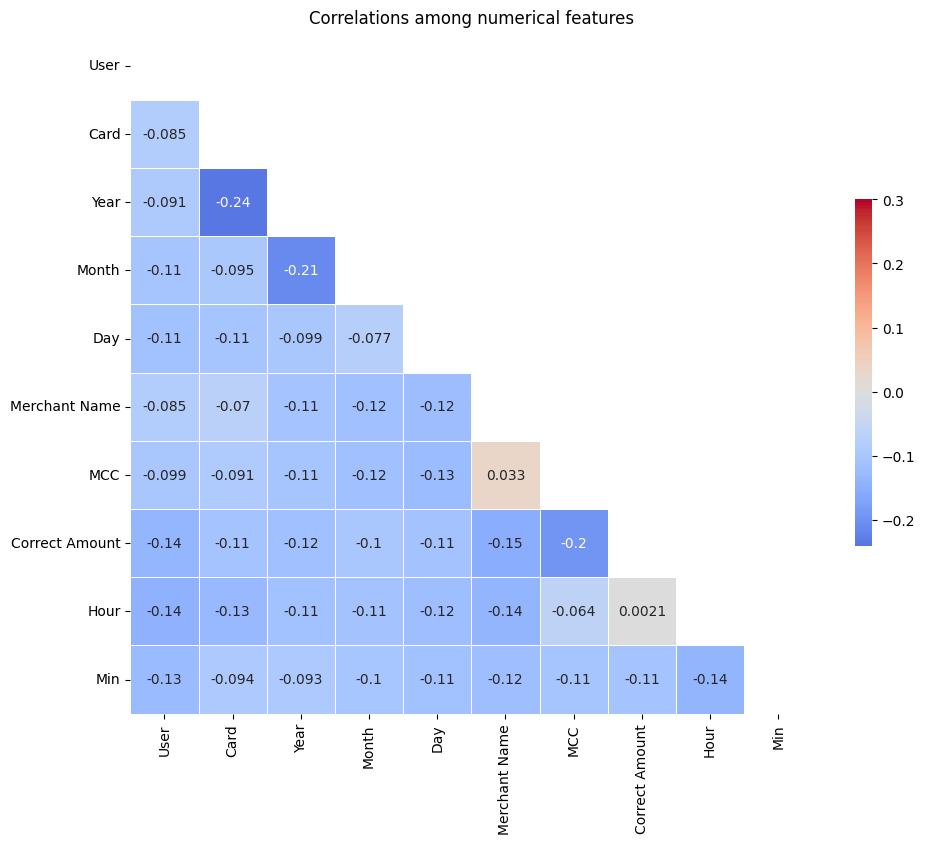

In [47]:
# Plot computed correlation

df_plot = pd.DataFrame(data = corr_matrix, index=cols_corr, columns=cols_corr)
plotCorrelationMatrix(df_plot, annot=True)
plt.title('Correlations among numerical features')
plt.show()

### Get the overall picture

Besides the correlation matrix above, we are going to view and/or visualize data to learn about different trends like:
- Counting and amount of transactions.
- Card usage over time.
- Channel of transactions.


In particular, it seems appropriate to look more carefully at the fraud situations.

Feel free to add and/or remove visualizations.


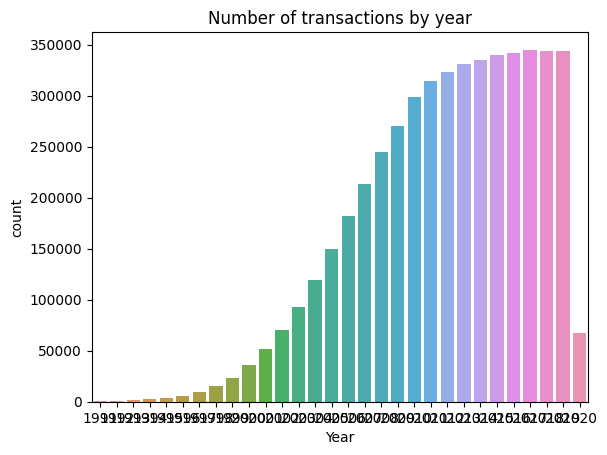

In [48]:
# Number of transactions by year

df_plot = ( df_clean
                .groupby('Year')
                .count()
                .sort('Year', ascending=True)
                .toPandas()
          )
plotBar(df_plot, 'Year', 'count')
plt.title('Number of transactions by year')
plt.show()

In [49]:
df_plot.head()

,Year,count
0,1991,331
1,1992,1005
2,1993,1663
3,1994,2819
4,1995,4052


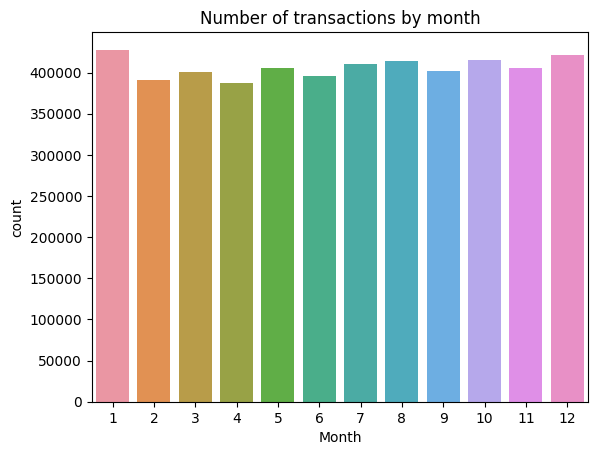

In [50]:
# Number of transactions by month

df_plot = ( df_clean
                
          )
plotBar(df_plot, 'Month', 'count')
plt.title('Number of transactions by month')
plt.show()

In [51]:
df_plot.head()

,Month,count
0,1,427834
1,2,391536
2,3,400966
3,4,387974
4,5,405392


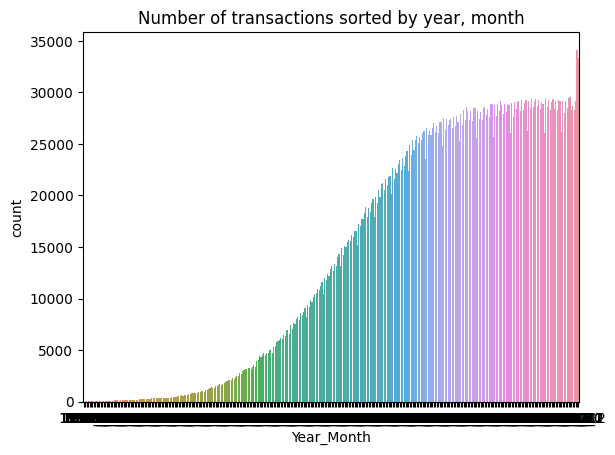

In [52]:
# Number of transactions by year - month

df_plot = ( df_clean
            .groupby(['Year', 'Month'])
            .count()
            .sort('Year', 'Month', ascending=True)
            .withColumn('Year_Month', F.concat('Year',F.lit('_'),'Month'))
            .toPandas()
          )
plotBar(df_plot, 'Year_Month', 'count')
plt.title('Number of transactions sorted by year, month')
plt.show()

In [53]:
df_plot.head()

,Year,Month,count,Year_Month
0,1991,1,12,1991_1
1,1991,2,12,1991_2
2,1991,3,9,1991_3
3,1991,4,11,1991_4
4,1991,5,8,1991_5


In [54]:
# Counting of fraudulent transactions or not

df_clean.

+---------+-------+
|Is Fraud?|  count|
+---------+-------+
|       No|4872272|
|      Yes|   6004|
+---------+-------+



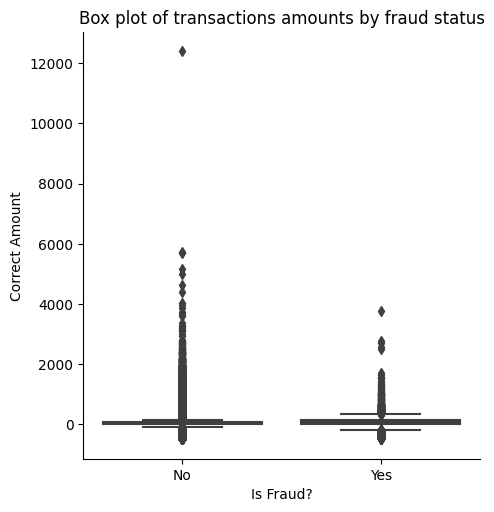

In [55]:
# Transactions amounts by fraud status

df_plot = df_clean.select('Correct Amount', 'Is Fraud?').toPandas()
plotBox(df_plot, 'Is Fraud?', 'Correct Amount')
plt.title('Box plot of transactions amounts by fraud status')
plt.show()

In [56]:
df_plot.head()

,Correct Amount,Is Fraud?
0,134.089996,No
1,38.480000,No
2,86.190002,No
3,57.099998,No
4,53.910000,No


In [ ]:
# Checking fraudulent transactions

df_fraud = df_clean.
df_fraud.show(10)

In [58]:
# Fraudulent transactions by location

( df_fraud
     
 
)

+--------------+-----+
|Merchant State|count|
+--------------+-----+
|          null| 3702|
|         Italy|  933|
|            OH|  186|
|            CA|  143|
|       Algeria|  141|
|            TX|   68|
|            FL|   66|
|        Mexico|   62|
|         Haiti|   59|
|        Turkey|   54|
+--------------+-----+
only showing top 10 rows



In [59]:
# Fraudulent transactions by user

( df_fraud
     
 
)


+----+-------------------+
|User|sum(Correct Amount)|
+----+-------------------+
|   1|  4172.230099260807|
|1880|  3714.309942016378|
| 817|  3682.539996881038|
| 629|  3388.589950799942|
| 275| 3387.1799211502075|
|1248| 3300.0499760191888|
|1946| 3215.8398983478546|
|1889| 3155.9099329710007|
| 580|  2989.159905999899|
|1338| 2986.4600098133087|
+----+-------------------+
only showing top 10 rows



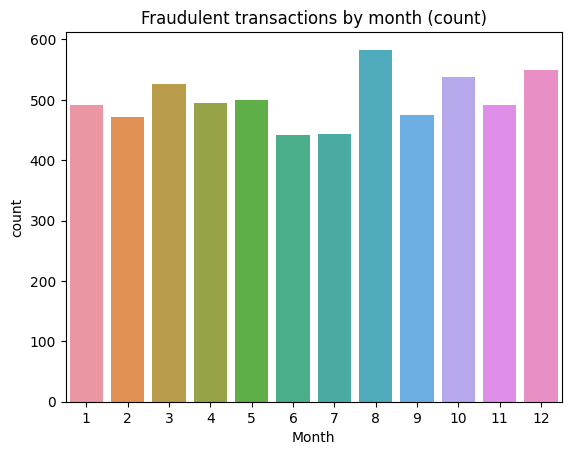

In [60]:
# Fraudulent transactions by month (count)

df_plot = ( df_fraud
            
           
          )
plotBar(df_plot, 'Month', 'count')
plt.title('Fraudulent transactions by month (count)')
plt.show()

In [61]:
df_plot.head()

,Month,count
0,8,583
1,12,550
2,10,537
3,3,526
4,5,499


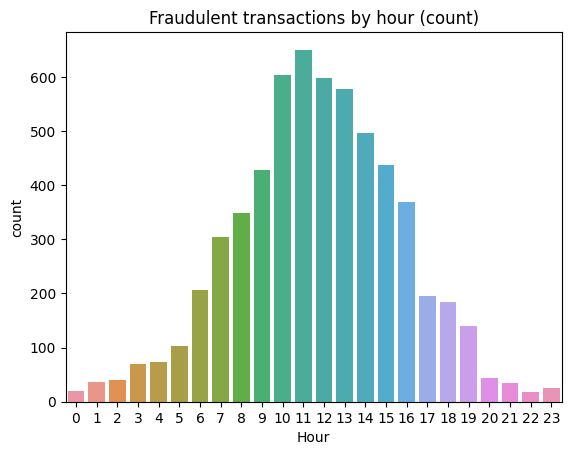

In [62]:
# Fraudulent transactions by hour (count)

df_plot = ( df_fraud
               
          )
plotBar(df_plot, 'Hour', 'count')
plt.title('Fraudulent transactions by hour (count)')
plt.show()

In [63]:
df_plot.head()

,Hour,count
0,11,650
1,10,603
2,12,597
3,13,578
4,14,496


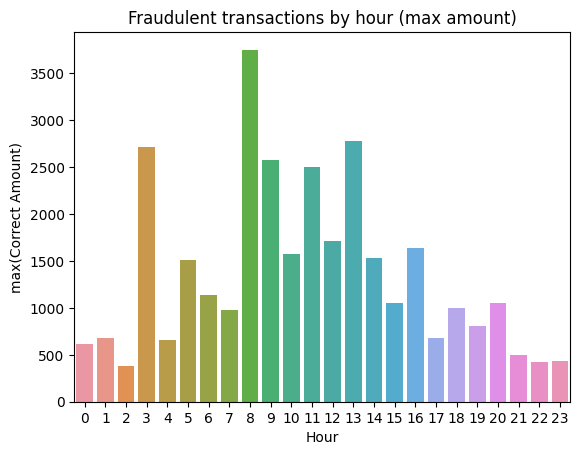

In [64]:
# Fraudulent transactions by hour (max amount)

df_plot = ( df_fraud
           .select('Hour', 'Correct Amount')
           .groupBy('Hour')
           .agg(F.max('Correct Amount'))
           .sort('Hour', ascending=True)
           .toPandas()
          )
plotBar(df_plot, 'Hour', 'max(Correct Amount)')
plt.title('Fraudulent transactions by hour (max amount)')
plt.show()

In [65]:
df_plot.head()

,Hour,max(Correct Amount)
0,0,609.979980
1,1,684.159973
2,2,385.660004
3,3,2708.899902
4,4,660.760010


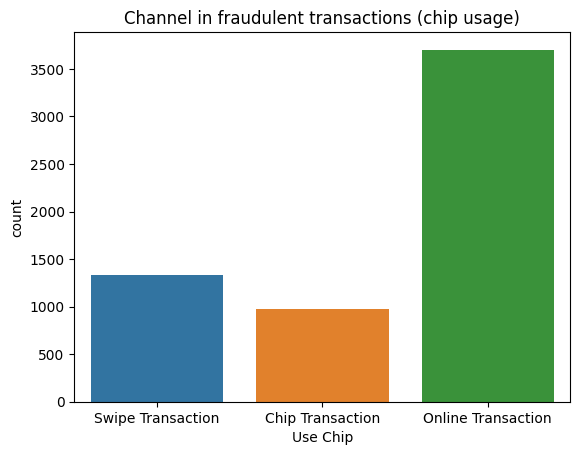

In [66]:
# Channel in fraudulent transactions (chip usage)

df_plot = df_fraud.groupBy('Use Chip').count().toPandas()
plotBar(df_plot, 'Use Chip', 'count')
plt.title('Channel in fraudulent transactions (chip usage)')
plt.show()

In [67]:
df_plot.head()

,Use Chip,count
0,Swipe Transaction,1332
1,Chip Transaction,970
2,Online Transaction,3702


In [ ]:
# Channel in all transactions (chip usage)

df_plot = 

plotBar(df_plot, 'Use Chip', 'count')
plt.title('Channel in all transactions (chip usage)')
plt.show()

In [69]:
df_plot.head()

,Use Chip,count
0,Swipe Transaction,3078037
1,Chip Transaction,1256053
2,Online Transaction,544186


## Columns selection, encoding and vector assembling

It is time to start thinking about which columns to use in the model, whether existing or new derived ones. To do so, the best we understand what the business is all about the better, including in relation to the characteristics of the data we were given. Statistics that we have made, and more we might do, would help to figure out patterns of interest.

Once the columns of interest for the classifer are set out, we have to enter into the specifics of the algorithms. 

We are going to use `StringIndexer` and `OneHotEncoder`, as the ML algorithms we are about to use do require processing numbers not text. And because of those algorithms also requiring that all input features are contained within a single vector, we need a transformation. So we use the `VectorAsAssembler` transformer, already used above.

Also, we have to make sure that the column target (binary label) is of numeric type.

Notes:
- MLlib provides a set of tools to help tackling this issue of features. See http://spark.apache.org/docs/latest/ml-features.html .
- Another functionality we could use is Imputer, which completes missing values in a dataset, using the mean, median or mode of the columns in which the missing values are located. The input columns have to be of numeric type. 
- There are still nulls or NaN in the columns `Merchant State` and `Zip`. We should sort it out. But such information can be extracted from the column `Merchant City` so we will drop the two columns for the time being.



### Column target or label

In [70]:
df_clean = ( df_clean
                .withColumn("Fraud", F.when(F.col('Is Fraud?')=='Yes', 1).otherwise(0))
            )


In [71]:
df_clean.printSchema()
transactions_cols_interest = df_clean.columns
transactions_cols_interest

root
 |-- User: integer (nullable = true)
 |-- Card: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Use Chip: string (nullable = true)
 |-- Merchant Name: long (nullable = true)
 |-- Merchant City: string (nullable = true)
 |-- Merchant State: string (nullable = true)
 |-- Zip: double (nullable = true)
 |-- MCC: integer (nullable = true)
 |-- Is Fraud?: string (nullable = true)
 |-- Correct Amount: float (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Min: integer (nullable = true)
 |-- Fraud: integer (nullable = false)



['User',
 'Card',
 'Year',
 'Month',
 'Day',
 'Time',
 'Use Chip',
 'Merchant Name',
 'Merchant City',
 'Merchant State',
 'Zip',
 'MCC',
 'Is Fraud?',
 'Correct Amount',
 'Hour',
 'Min',
 'Fraud']

### Features to use

In order to select the features to use, one should also take into account the correlations among them. 

But as a starting experiment, let us use as many as possible.

In [72]:
cls_not_features = ['Time', 'Merchant State', 'Zip', 'Is Fraud?', 'Fraud'] 
cls_numeric = ['User', 'Card', 'Year', 'Month', 'Day', 'Merchant Name',
               'Zip', 'MCC', 'Correct Amount', 'Hour', 'Min', 'Fraud']
cls_non_numeric = 
cls_non_numeric

['Time', 'Use Chip', 'Merchant City', 'Merchant State', 'Is Fraud?']

In [73]:
# Encoding columns and vector assembling them
# See Chapter 10 of the book "Learning Spark - Lightning-Fast Data Analytics"

categorical_cols = [i for i in cls_non_numeric if i not in cls_not_features]
non_categorical_cols = [i for i in cls_numeric if i not in cls_not_features]

index_output_cols = [x + ' Index' for x in categorical_cols]
ohe_output_cols = [x + ' OHE' for x in categorical_cols]

string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid="skip")

ohe_encoder = OneHotEncoder(inputCols=index_output_cols, outputCols=ohe_output_cols)
   
# Put all input features into a single vector, by using a transformer

assembler_inputs = ohe_output_cols + non_categorical_cols
vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
assembler_inputs

['Use Chip OHE',
 'Merchant City OHE',
 'User',
 'Card',
 'Year',
 'Month',
 'Day',
 'Merchant Name',
 'MCC',
 'Correct Amount',
 'Hour',
 'Min']

In [74]:
categorical_cols

['Use Chip', 'Merchant City']

In [75]:
non_categorical_cols

['User',
 'Card',
 'Year',
 'Month',
 'Day',
 'Merchant Name',
 'MCC',
 'Correct Amount',
 'Hour',
 'Min']

# Select and train model

Now it is time to train and test a model to be used for binary classification, that is, to decide whether there is a fraud or not.

We are going to use a Linear Support Vector Machine algorithm, as presented in
http://spark.apache.org/docs/latest/ml-classification-regression.html#linear-support-vector-machine . 

But at this point in time, probably it is worth considering to look at both the supervised learning and the ML pipeline slides from the lectures.

## Train/test split

The step of creating a ML model means we should keep some part of the data in the dark.
Basic standard split is 80/20 (or 70/30 if dataset is large), assuming that we opt for a train/test split rather than a train/validation/test split. 

Recall that if the test part is relatively too small, then the model will memorize the data so it will reach an overfit situation. That would be bad as it no longer have data to evaluate how well it will generalize to unseen data.

Notice that data for fraudulent cases is less and imbalanced. Ideally, we should carry out better tuning for the train/test split, as it affects the performance of the model as we might conclude later on.


In [ ]:
# train/test split

df_train, df_test = df_clean.randomSplit([0.8, 0.2], 42) 

# Caching data ... just the training part as it is accessed many times by the algorithm
# But, it might not be a good idea if we are using a local computer and large dataset!
# df_train.cache()

# Print the number of rows in each part
print(f"There are {df_train.count()} rows in the training set and {df_test.count()} in the test set.")


**Notice:** 

As we did with clean data, we may consider storing the data split into files, should we want to use it elsewhere. 

This relates to the need of guaranteeing unicity in a different environment. 
We leave it as it is now.

## Linear SVM model

Once we have a vector assembled with the features in place, then we can use the `Linear SVM` estimator (the algorithm) to learn from the training data and to build the model. 

In [77]:
# Linear SVC algorithm
# default: featuresCol='features', labelCol='label', predictionCol='prediction'

lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol='Fraud')


## ML pipeline configuration

In [78]:
# The pipeline holds four stages as set above: 
#  1. string_indexer 
#  2. ohe_encoder
#  3. vec_assembler (related to assembling features into vector) 
#  4. lsvc (related to ML estimator)

pipeline = Pipeline(stages=[string_indexer, ohe_encoder, vec_assembler, lsvc])


## Model fitting
Get the model (as transformer) by fitting the pipeline to the training data.

In [ ]:
pipeline_model = pipeline.fit(df_train)


# Evaluate model

Let us evaluate the Linear SVM model that has been built.

## Testing the model

It is time to apply the model built to test data. Again, we will use the pipeline set above, meaning the stages already specified will be reused. Notice that, since the pipeline model is a transformer, we can easily apply it to test data.

In [80]:
# Make predictions on test data and show values of columns of interest

df_prediction = pipeline_model.transform(df_test)

# Check its schema

df_prediction.printSchema()


root
 |-- User: integer (nullable = true)
 |-- Card: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Use Chip: string (nullable = true)
 |-- Merchant Name: long (nullable = true)
 |-- Merchant City: string (nullable = true)
 |-- Merchant State: string (nullable = true)
 |-- Zip: double (nullable = true)
 |-- MCC: integer (nullable = true)
 |-- Is Fraud?: string (nullable = true)
 |-- Correct Amount: float (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Min: integer (nullable = true)
 |-- Fraud: integer (nullable = false)
 |-- Use Chip Index: double (nullable = false)
 |-- Merchant City Index: double (nullable = false)
 |-- Use Chip OHE: vector (nullable = true)
 |-- Merchant City OHE: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [81]:
# Columns to be focus on

df_prediction.


23/03/17 20:22:26 WARN DAGScheduler: Broadcasting large task binary with size 1500.6 KiB


+--------------------+--------------------+----------+-----+
|            features|       rawPrediction|prediction|Fraud|
+--------------------+--------------------+----------+-----+
|(11838,[0,762,118...|[2.00992197805789...|       0.0|    0|
|(11838,[0,529,118...|[2.00260482636364...|       0.0|    0|
|(11838,[0,173,118...|[1.99734976842966...|       0.0|    0|
|(11838,[0,529,118...|[2.01024919177608...|       0.0|    0|
|(11838,[0,762,118...|[2.01102023719275...|       0.0|    0|
|(11838,[0,529,118...|[2.00373077950577...|       0.0|    0|
|(11838,[0,529,118...|[1.99980534341225...|       0.0|    0|
|(11838,[0,529,118...|[1.99910034086769...|       0.0|    0|
|(11838,[0,529,118...|[2.00663706437133...|       0.0|    0|
|(11838,[0,529,118...|[2.01055392530275...|       0.0|    0|
|(11838,[0,762,118...|[2.00151796178571...|       0.0|    0|
|(11838,[0,529,118...|[2.02055611367043...|       0.0|    0|
|(11838,[0,529,118...|[2.00945109951328...|       0.0|    0|
|(11838,[0,173,118...|[1

## Evaluation metrics

How right was the model? Let us figure out using:
1. Specific evaluator
2. Confusion matrix


In [82]:
# Compute evaluation metrics on test data

prediction_label = df_prediction.select('rawPrediction', 'prediction', 'Fraud')  

# supports metricName="areaUnderROC" (default) and "areaUnderPR"
# it relates to sensitivity (TP rate) and specificity (FP rate)

evaluator = BinaryClassificationEvaluator(labelCol='Fraud')

print("areaUnderROC = " + str(evaluator.evaluate(prediction_label)))
# print("areaUnderPR = " + str(evaluator.evaluate(prediction_label, {evaluator.metricName: 'areaUnderPR'})))


23/03/17 20:22:29 WARN DAGScheduler: Broadcasting large task binary with size 1498.9 KiB


areaUnderROC = 0.9012415626377711


Recalling the confusion matrix:

- True Positive: the prediction was positive and it is true. 
- True Negative: the prediction was negative and it is true. 
- False Positive: the prediction was positive and it is false. 
- False Negative: the prediction was negative and it is false. 


 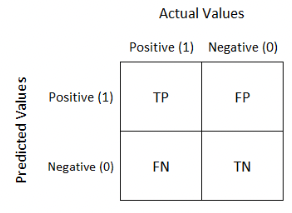

It follows the TP, TN, FP and FN computations.

In [ ]:
# Counting rows for each case TP, TN, FP and FN respectively

n = df_prediction.count()
tp = df_prediction.filter(F.expr('prediction > 0') & F.expr('Fraud == prediction')).count()
tn = df_prediction.filter
fp = df_prediction.filter
fn = n - tp - tn - fp
[tp, tn, fp, fn, n]


**Accuracy** = (TP + TN) / (TP + TN + FP + FN)

How often the classifier is correct? (score)

Metric widely used but not so useful when there are many TN cases.

In [84]:
accuracy = (tp + tn) / (tp + tn + fp + fn)

**Precision** = TP / (TP + FP)

Positive predictive value - proportion of positive results that were correctly identified.

It removes NP and FN from consideration.

In [85]:
precision = tp / (tp + fp)

**Recall** = TP / (TP + FN)

True positive rate. (hit rate, sensitivity)

In [86]:
recall = tp / (tp + fn)

**Specifity** = TN / (TN + FP)

True negative rate. (selectivity)

In [87]:
specificity = tn / (tn + fp)

**F1 score** = 2 * Recall * Precision / (Recall + Precision)

Useful metric because it is difficult to compare two models with low precision and high recall or vice versa. 
Indeed, by combining recall and precision it helps to measure them at once.


In [88]:
f1_score = 2 * recall * precision / (recall + precision)

In [89]:
# Confusion matrix conclusions

print("TP = {}, TN = {}, FP = {}, FN = {}, Total = {}".format(tp, tn, fp, fn, n)) 
print("Accuracy = {}".format(accuracy))
print("Precison = {}".format(precision))
print("Recall = {}".format(recall))
print("Specificity = {}".format(specificity))
print("F1 score = {}".format(f1_score))

TP = 41, TN = 973414, FP = 15, FN = 1155, Total = 974625
Accuracy = 0.9987995382839554
Precison = 0.7321428571428571
Recall = 0.034280936454849496
Specificity = 0.9999845905556543
F1 score = 0.06549520766773162


**Questions and/or considerations:**

- *Which of the above metrics are most relevant for performance analysis in this particular study, considering the dataset that has been used?*


- *Precision is very low due to the fact that the dataset is imbalanced, with true negatives having a much larger number of instances than true positives. In order to further improve results, it would be nice to train the model on more balanced datasets.* 

## Visual analysis
Plotting `prediction` versus `Fraud` obtained above.

In [90]:
# Plots

# We leave it as exercise

## Saving the pipeline

In [91]:
# We can save the pipeline for further use should it be required

pipeline.save("pipeline-LinearSVM")

# later on, it can be loaded anywhere


In [92]:
# Furthermore, we can save the pipeline after fit, that is, the model

pipeline_model.save("model-LinearSVM")

In [93]:
# ! ls -la

In [94]:
# ! ls -la pipeline-LinearSVM

# Tune model

We should improve the model. For example, we can think about:
- How can we interpret the scores above?
- How to handle class imbalance, so clear in this dataset?
- Could a model with different set of features and/or target engineering would perform better? 
- And what about using real-time data, that is, not training nor testing data?

See the exercises below.

# Additional exercises

## ML model improvement
Once this exercise has been completed, create one or more notebooks with similar implementation but using
the following classifiers instead:
1. Logistic Regression 
2. Decision Tree

Also, try to improve the process of feature/target engineering, giveng the framework set out. By the way, now you must take into account correlations among features.

See related information in:
http://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression (http://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression)

http://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier (http://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier)


## Consuming profile

Using also the `User` and `Cards`datasets, create a new notebook to profile the usage of the credit cards.
Make sure you have a careful working plan designed in order to reach the goals.


# References

* Learning Spark - Lightning-Fast Data Analytics, 2nd Ed. J. Damji, B. Wenig, T. Das, and D. Lee. O'Reilly, 2020
* Spark: The Definitive Guide - Big Data Processing Made Simple, 1st Ed. B. Chambers and M. Zaharia. O'Reilly, 2018
* http://spark.apache.org/docs/latest/ml-guide.html
* https://docs.python.org/3/ 
* https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions
